# 보스턴 집값 예측하기 - 다항회귀 

## #01. 패키지 설치

In [20]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## #02. 데이터셋 준비

In [2]:
origin = read_excel("https://data.hossam.kr/E04/boston.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CRIM       506 non-null    float64
 1   ZN         506 non-null    float64
 2   INDUS      506 non-null    float64
 3   CHAS       506 non-null    int64  
 4   NOX        506 non-null    float64
 5   RM         506 non-null    float64
 6   AGE        506 non-null    float64
 7   DIS        506 non-null    float64
 8   RAD        506 non-null    int64  
 9   TAX        506 non-null    int64  
 10  PTRATIO    506 non-null    float64
 11  B          506 non-null    float64
 12  LSTAT      506 non-null    float64
 13  MEDV       506 non-null    float64
 14  CAT. MEDV  506 non-null    int64  
dtypes: float64(11), int64(4)
memory usage: 59.4 KB


## #03. 데이터 전처리

### 결측치 확인

In [3]:
origin.isnull().sum()

CRIM         0
ZN           0
INDUS        0
CHAS         0
NOX          0
RM           0
AGE          0
DIS          0
RAD          0
TAX          0
PTRATIO      0
B            0
LSTAT        0
MEDV         0
CAT. MEDV    0
dtype: int64

## #04. 탐색적 데이터 분석

### 명목형 처리

In [4]:
origin['CHAS'] = origin['CHAS'].astype('category')
origin['CAT. MEDV'] = origin['CAT. MEDV'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CRIM       506 non-null    float64 
 1   ZN         506 non-null    float64 
 2   INDUS      506 non-null    float64 
 3   CHAS       506 non-null    category
 4   NOX        506 non-null    float64 
 5   RM         506 non-null    float64 
 6   AGE        506 non-null    float64 
 7   DIS        506 non-null    float64 
 8   RAD        506 non-null    int64   
 9   TAX        506 non-null    int64   
 10  PTRATIO    506 non-null    float64 
 11  B          506 non-null    float64 
 12  LSTAT      506 non-null    float64 
 13  MEDV       506 non-null    float64 
 14  CAT. MEDV  506 non-null    category
dtypes: category(2), float64(11), int64(2)
memory usage: 52.7 KB


### 기본통계 확인

In [5]:
origin.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### 상자그림

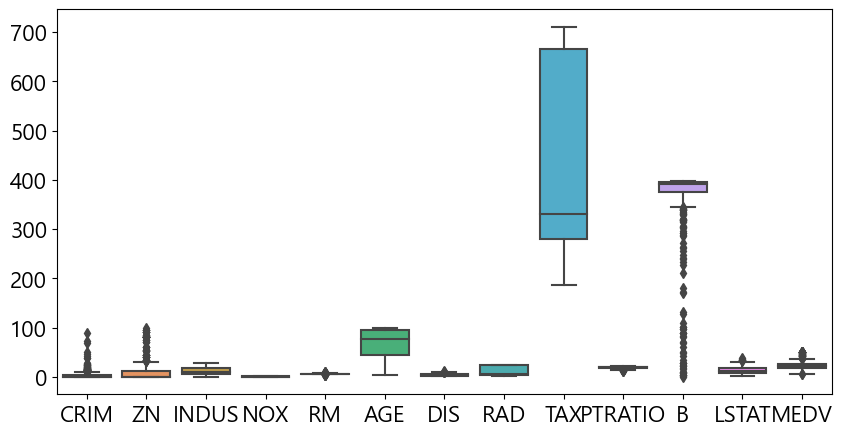

In [6]:
plt.figure(figsize=(10,5))
sb.boxplot(data=origin)
plt.show()
plt.close()

### 산점도 그래프와 추세선 확인

In [7]:
# plt.figure(figsize=(30,30))
# sb.pairplot(data=origin)
# plt.show()
# plt.close()

### 상관계수 확인

In [8]:
corr = origin.drop('MEDV', axis=1).corr()
corr

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CAT. MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.151987
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.365296
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.366276
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.108631
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.232502
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.641265
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.191196
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.118887
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.197924
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.273687


### 상관계수 히트맵

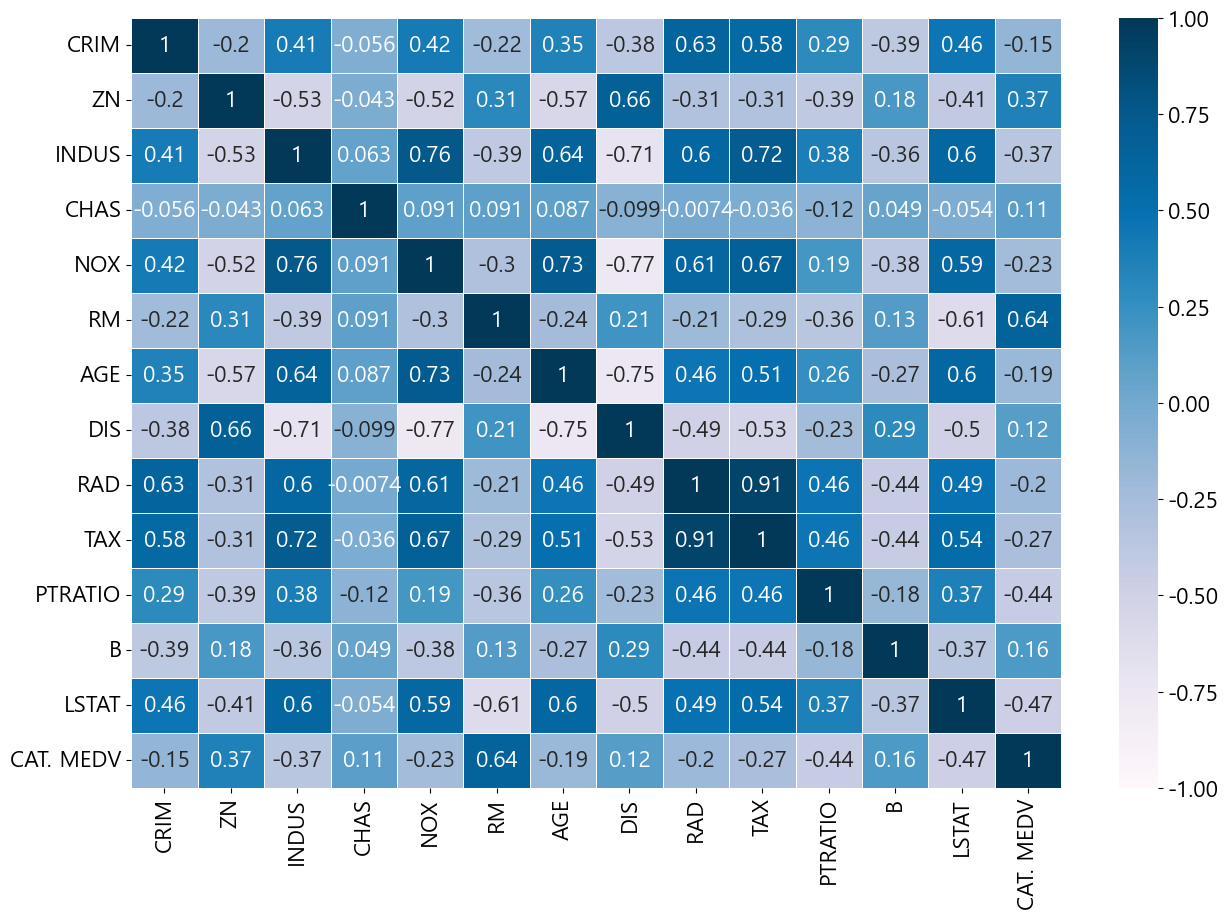

In [9]:
plt.figure(figsize=(15,10))
sb.heatmap(corr, annot=True, cmap='PuBu', vmin=-1, vmax=1, linewidths=0.5)
plt.show()
plt.close()

### 제외하기로 한 독립변수 제거
> 상관계수의 절대값이 0.7이상인 항목을 순차적으로 제거하여 회귀분석에 사용할 요인을 선정

In [10]:
x = origin.drop(['TAX','DIS','NOX','INDUS'], axis=1)
x

,CRIM,ZN,CHAS,RM,AGE,RAD,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,0,6.575,65.2,1,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,0,6.421,78.9,2,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,0,7.185,61.1,2,17.8,392.83,4.03,34.7,1
3,0.03237,0.0,0,6.998,45.8,3,18.7,394.63,2.94,33.4,1
4,0.06905,0.0,0,7.147,54.2,3,18.7,396.90,5.33,36.2,1
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,0,6.593,69.1,1,21.0,391.99,9.67,22.4,0
502,0.04527,0.0,0,6.120,76.7,1,21.0,396.90,9.08,20.6,0
503,0.06076,0.0,0,6.976,91.0,1,21.0,396.90,5.64,23.9,0
504,0.10959,0.0,0,6.794,89.3,1,21.0,393.45,6.48,22.0,0


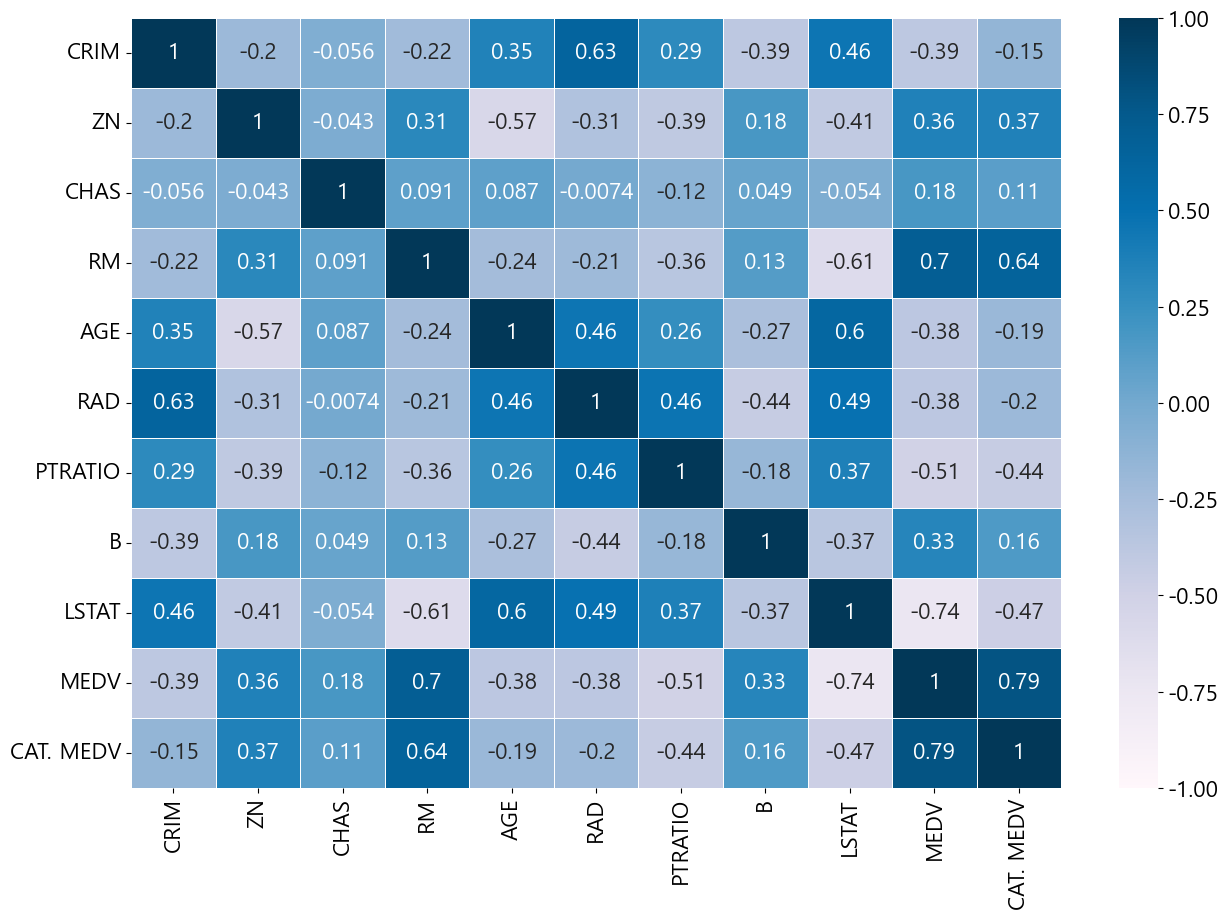

In [11]:
plt.figure(figsize=(15,10))
sb.heatmap(x.corr(), annot=True, cmap='PuBu', vmin=-1, vmax=1, linewidths=0.5)
plt.show()
plt.close()

In [12]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CRIM       506 non-null    float64 
 1   ZN         506 non-null    float64 
 2   CHAS       506 non-null    category
 3   RM         506 non-null    float64 
 4   AGE        506 non-null    float64 
 5   RAD        506 non-null    int64   
 6   PTRATIO    506 non-null    float64 
 7   B          506 non-null    float64 
 8   LSTAT      506 non-null    float64 
 9   MEDV       506 non-null    float64 
 10  CAT. MEDV  506 non-null    category
dtypes: category(2), float64(8), int64(1)
memory usage: 36.9 KB


### 명목형 변수만 추출

In [13]:
categorical_df = x.filter(['CHAS','CAT','MEDV'])
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   CHAS    506 non-null    category
 1   MEDV    506 non-null    float64 
dtypes: category(1), float64(1)
memory usage: 4.7 KB


### 종속변수만 추출

In [14]:
y = x['MEDV']
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

### 데이터프레임에서 추출한 필드를 제거

In [15]:
x.drop(['CHAS','CAT. MEDV', 'MEDV'], axis=1, inplace=True)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   RM       506 non-null    float64
 3   AGE      506 non-null    float64
 4   RAD      506 non-null    int64  
 5   PTRATIO  506 non-null    float64
 6   B        506 non-null    float64
 7   LSTAT    506 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 31.8 KB


### 최종 산점도 행렬 확인

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

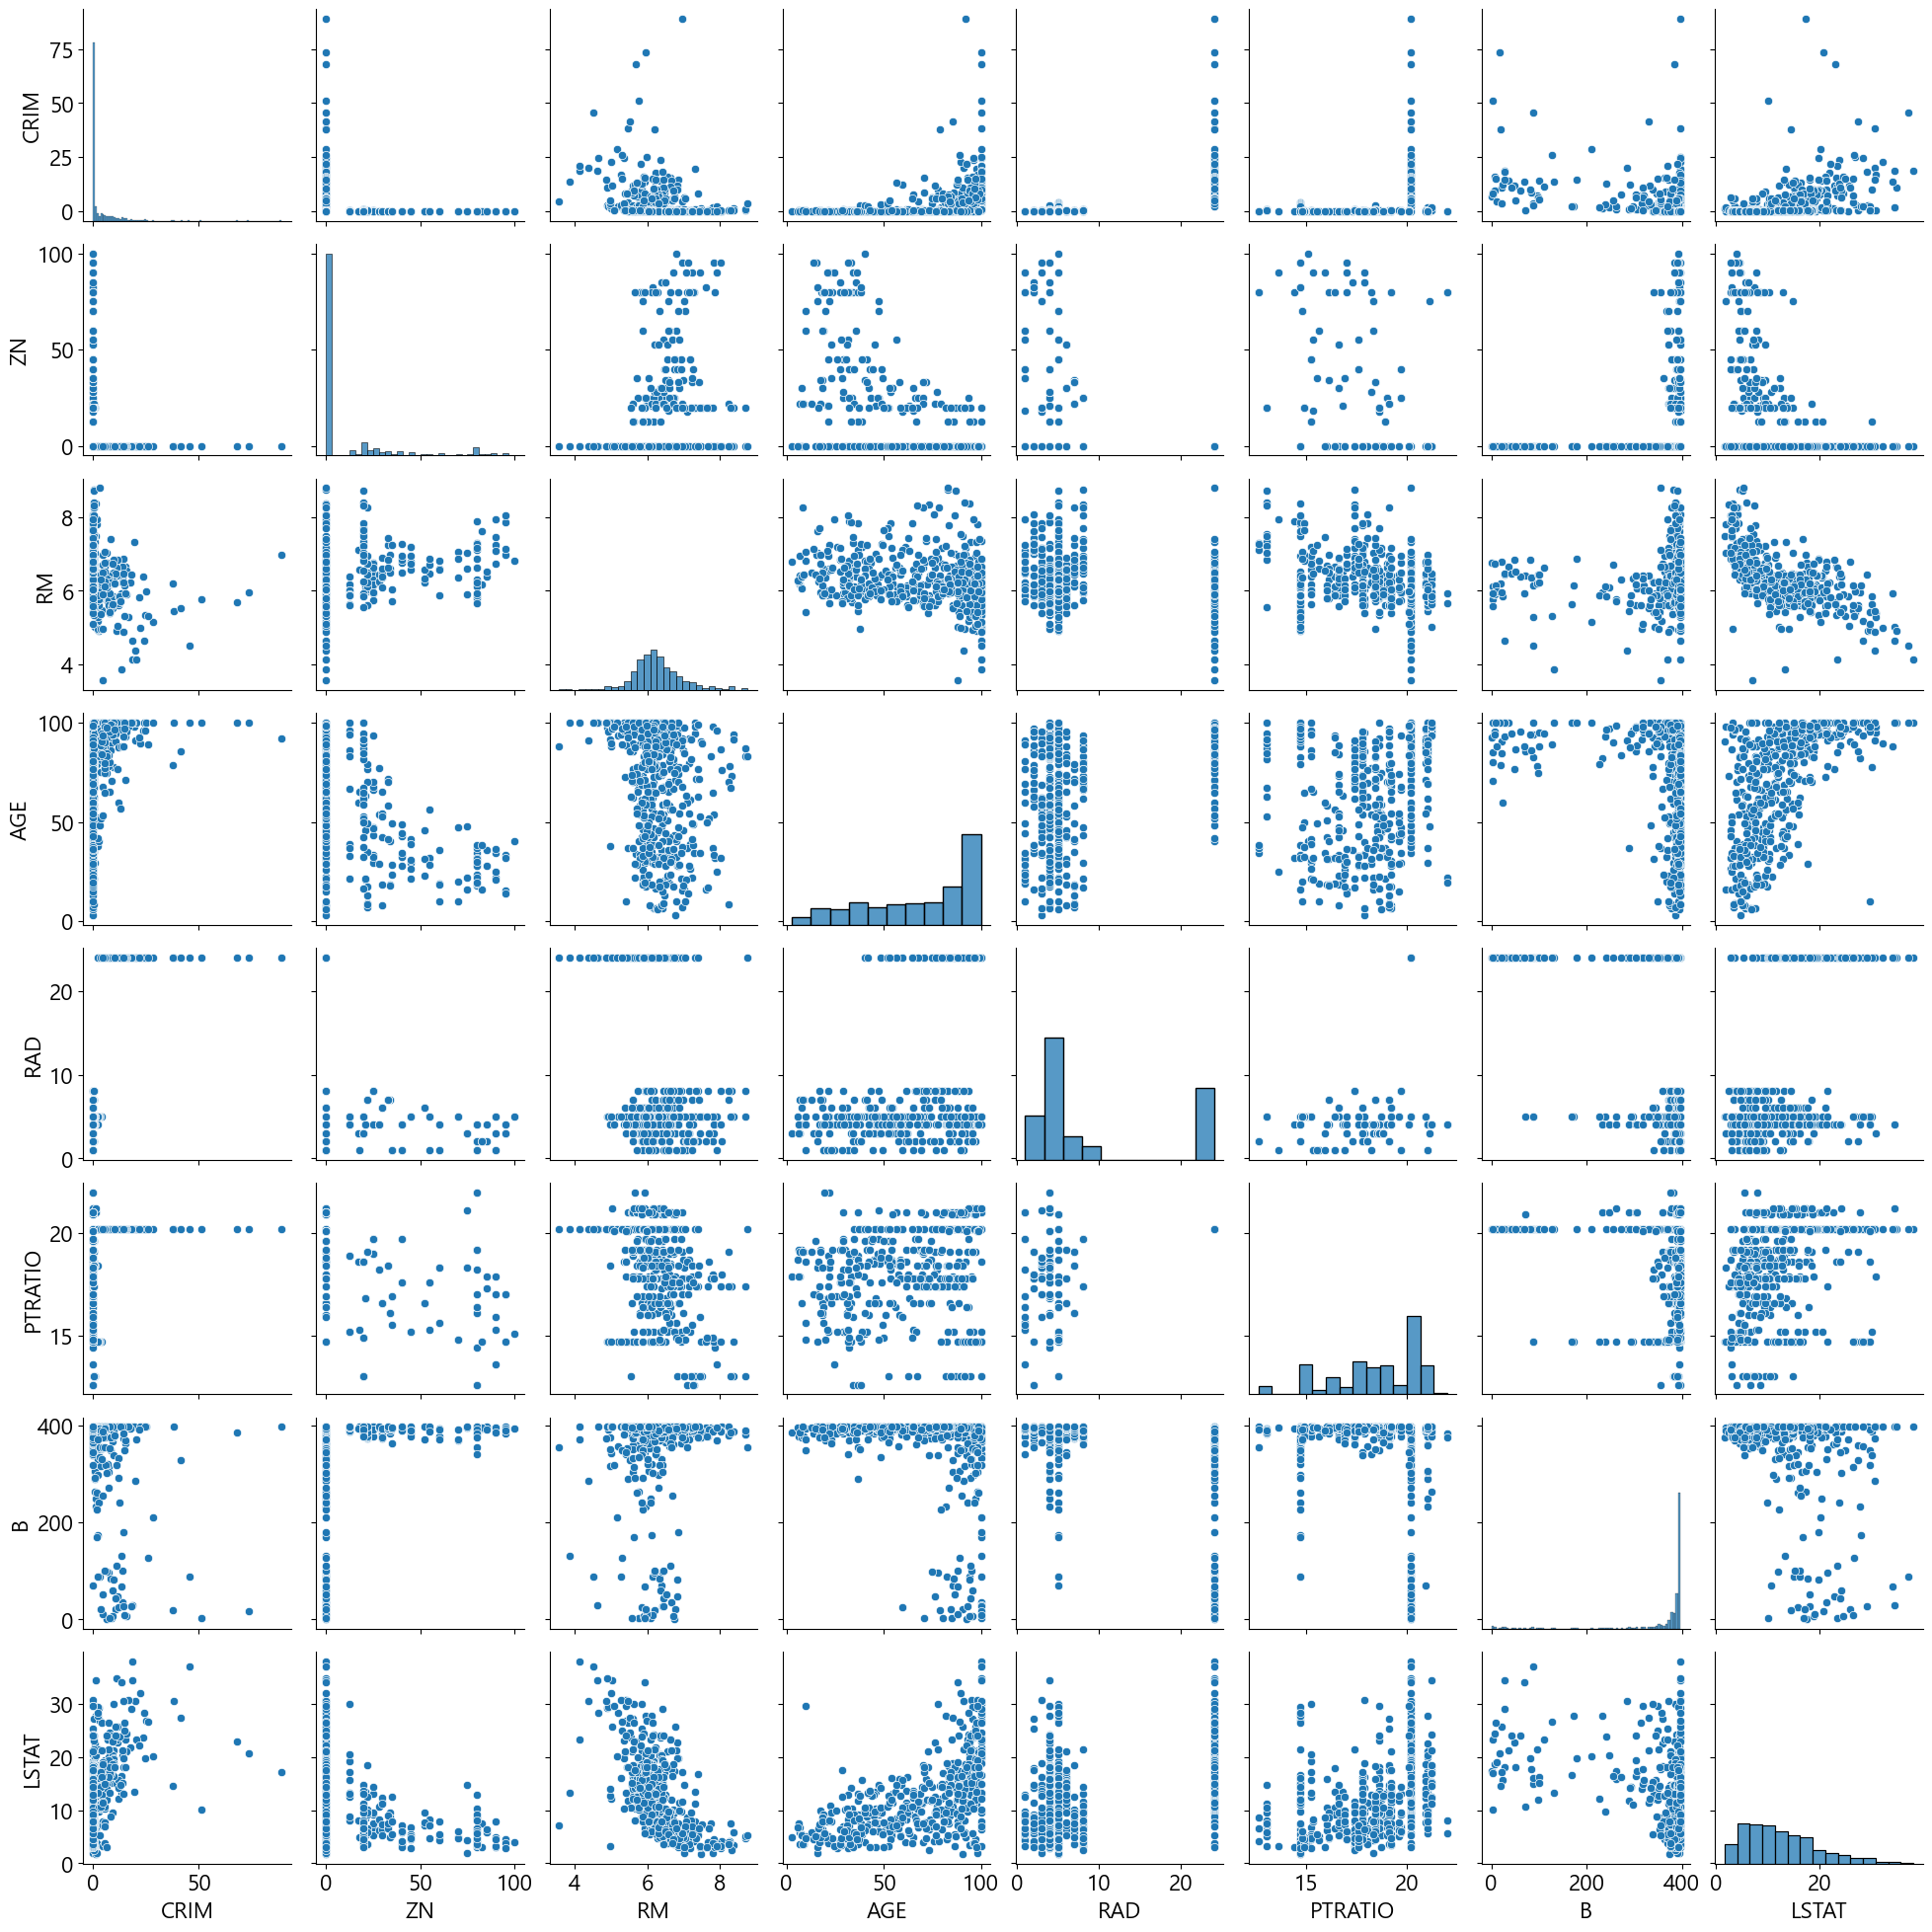

In [16]:
plt.figure(figsize=(30,30))
sb.pairplot(x)
plt.show()
plt.savefig("pairplot.png")
plt.close()

## #05. 데이터 분리

### 랜덤시드 고정

In [17]:
np.random.seed(777)

### 데이터 표준화

In [18]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x)
x_scale

array([[-0.41978194,  0.28482986,  0.41367189, ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236,  0.19427445, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236,  1.28271368, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.98496002, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.72567214, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236, -0.36276709, ...,  1.17646583,
         0.44105193, -0.66905833]])

### 표준화 결과를 다항식으로 변환

In [19]:
x_scale_df = DataFrame(x_scale, columns=x.columns)
x_scale_df

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT
0,-0.419782,0.284830,0.413672,-0.120013,-0.982843,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,0.194274,0.367166,-0.867883,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,1.282714,-0.265812,-0.867883,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,1.016303,-0.809889,-0.752922,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,1.228577,-0.511180,-0.752922,0.113032,0.441052,-1.026501
...,...,...,...,...,...,...,...,...
501,-0.413229,-0.487722,0.439316,0.018673,-0.982843,1.176466,0.387217,-0.418147
502,-0.415249,-0.487722,-0.234548,0.288933,-0.982843,1.176466,0.441052,-0.500850
503,-0.413447,-0.487722,0.984960,0.797449,-0.982843,1.176466,0.441052,-0.983048
504,-0.407764,-0.487722,0.725672,0.736996,-0.982843,1.176466,0.403225,-0.865302


### 독립변수를 다항식으로 변환

In [21]:
poly = PolynomialFeatures(degree=2, include_bias=False)
fit = poly.fit_transform(x_scale_df)
x2 = DataFrame(fit, columns=poly.get_feature_names_out())
x2.head()

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT,CRIM^2,CRIM ZN,...,RAD^2,RAD PTRATIO,RAD B,RAD LSTAT,PTRATIO^2,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2
0,-0.419782,0.284830,0.413672,-0.120013,-0.982843,-1.459000,0.441052,-1.075562,0.176217,-0.119566,...,0.965980,1.433968,-0.433485,1.057109,2.128682,-0.643495,1.569246,0.194527,-0.474379,1.156834
1,-0.417339,-0.487722,0.194274,0.367166,-0.867883,-0.303094,0.441052,-0.492439,0.174172,0.203546,...,0.753220,0.263050,-0.382781,0.427380,0.091866,-0.133680,0.149255,0.194527,-0.217191,0.242497
2,-0.417342,-0.487722,1.282714,-0.265812,-0.867883,-0.303094,0.396427,-1.208727,0.174174,0.203547,...,0.753220,0.263050,-0.344052,1.049033,0.091866,-0.120155,0.366358,0.157154,-0.479172,1.461022
3,-0.416750,-0.487722,1.016303,-0.809889,-0.752922,0.113032,0.416163,-1.361517,0.173681,0.203258,...,0.566892,-0.085104,-0.313338,1.025116,0.012776,0.047040,-0.153895,0.173192,-0.566613,1.853728
4,-0.412482,-0.487722,1.228577,-0.511180,-0.752922,0.113032,0.441052,-1.026501,0.170141,0.201177,...,0.566892,-0.085104,-0.332078,0.772876,0.012776,0.049853,-0.116028,0.194527,-0.452740,1.053705


### 분리해 놓은 명목형 데이터와 결합
1. 명목형 변수의 값이 0,1  두 종류 밖에 없기 때문에 별도로 더미변수 처리는 필요없다.
2. 표준화의 결과와 병합이 필요하지만 표준화 함수는 리턴타입이 numpy array이므로 이를 다시 DataFrame으로 변환해야만 명목형과 결합이 가능하다.

In [22]:
x_df = merge(x2, categorical_df, left_index=True, right_index=True)
x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   CRIM           506 non-null    float64 
 1   ZN             506 non-null    float64 
 2   RM             506 non-null    float64 
 3   AGE            506 non-null    float64 
 4   RAD            506 non-null    float64 
 5   PTRATIO        506 non-null    float64 
 6   B              506 non-null    float64 
 7   LSTAT          506 non-null    float64 
 8   CRIM^2         506 non-null    float64 
 9   CRIM ZN        506 non-null    float64 
 10  CRIM RM        506 non-null    float64 
 11  CRIM AGE       506 non-null    float64 
 12  CRIM RAD       506 non-null    float64 
 13  CRIM PTRATIO   506 non-null    float64 
 14  CRIM B         506 non-null    float64 
 15  CRIM LSTAT     506 non-null    float64 
 16  ZN^2           506 non-null    float64 
 17  ZN RM          506 non-null    floa

### 훈련데이터와 검증데이터로 분할

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_df, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((354, 46), (152, 46), (354,), (152,))

## #06. 모델생성

In [24]:
# 모델 객체 생성
model = Sequential()

# 첫번째 층
model.add(Dense(64, activation='relu', input_shape=(len(x_train.columns), )))

# 은닉층
model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(4, activation='relu'))
# model.add(Dense(2, activation='relu'))

# 마지막 층
model.add(Dense(1, activation='linear'))

# 함수적용
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3008      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5121 (20.00 KB)
Trainable params: 5121 (20.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [25]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
12/12 [==============================] - 1s 15ms/step - loss: 514.5918 - mae: 20.8547 - val_loss: 351.7382 - val_mae: 17.2579 - lr: 0.0010
Epoch 2/500
12/12 [==============================] - 0s 4ms/step - loss: 275.0520 - mae: 15.3172 - val_loss: 181.1855 - val_mae: 12.3470 - lr: 0.0010
Epoch 3/500
12/12 [==============================] - 0s 4ms/step - loss: 128.9520 - mae: 10.3928 - val_loss: 63.9519 - val_mae: 7.3265 - lr: 0.0010
Epoch 4/500
12/12 [==============================] - 0s 4ms/step - loss: 37.3909 - mae: 5.4196 - val_loss: 11.2125 - val_mae: 2.9364 - lr: 0.0010
Epoch 5/500
12/12 [==============================] - 0s 4ms/step - loss: 8.5477 - mae: 2.1511 - val_loss: 4.1492 - val_mae: 1.5288 - lr: 0.0010
Epoch 6/500
12/12 [==============================] - 0s 4ms/step - loss: 4.3194 - mae: 1.3930 - val_loss: 1.5683 - val_mae: 1.0278 - lr: 0.0010
Epoch 7/500
12/12 [==============================] - 0s 4ms/step - loss: 1.4443 - mae: 0.9623 - val_loss: 1.3716 - va

## #07. 학습모델 평가

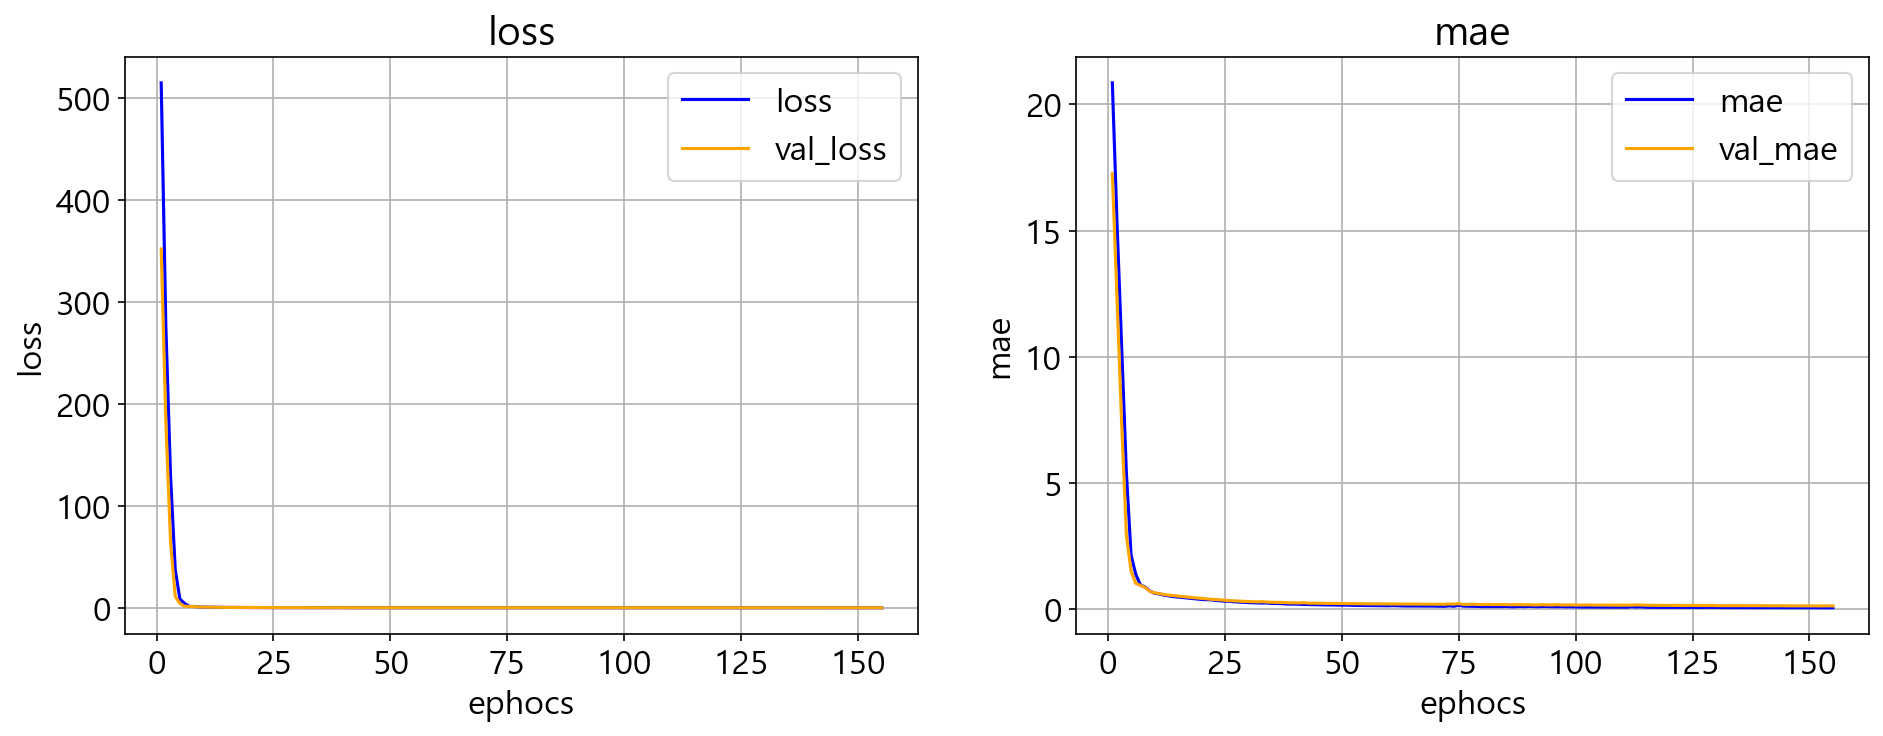

12/12 [==============================] - 0s 1ms/step - loss: 0.0059 - mae: 0.0575
최종 훈련 손실률: 0.005857, 최종 훈련 절대오차: 0.057538
5/5 [==============================] - 0s 1ms/step - loss: 0.0560 - mae: 0.1343
최종 검증 손실률: 0.055975, 최종 검증 절대오차: 0.134290


In [26]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))
evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

## #08. 학습모델 적용

### 테스트 데이터에 대한 예측 결과 산정

In [27]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

5/5 [==============================] - 0s 1ms/step


### 결과 데이터 셋 구성

In [28]:
# 훈련데이터
train_df = DataFrame(x_train, columns=x_train.columns)
train_df['관측치'] = y_train.values
train_df['예측치'] = train_pred.flatten()

train_df['훈련오차'] = train_df['관측치'] - train_df['예측치']

train_df.head()

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT,CRIM^2,CRIM ZN,...,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS,MEDV,관측치,예측치,훈련오차
372,0.541569,-0.487722,-0.583589,0.747665,1.661245,0.806576,-0.096421,-0.528885,0.293297,-0.264135,...,-0.077771,-0.426585,0.009297,0.050996,0.279719,1,50.0,50.0,49.754753,0.245247
18,-0.327103,-0.487722,-1.180521,-1.137046,-0.637962,1.176466,-0.742112,-0.134996,0.106997,0.159536,...,-0.873069,-0.158818,0.550730,0.100182,0.018224,0,20.2,20.2,20.097347,0.102653
185,-0.413480,-0.487722,-0.187534,0.008005,-0.752922,-0.303094,0.333711,0.069658,0.170966,0.201664,...,-0.101146,-0.021113,0.111363,0.023245,0.004852,0,29.6,29.6,29.393099,0.206901
57,-0.418851,3.804234,0.757015,-0.998360,-0.523001,-1.551473,0.397194,-1.219941,0.175436,-1.593407,...,-0.616236,1.892706,0.157763,-0.484554,1.488257,0,31.6,31.6,31.567299,0.032701
261,-0.358360,0.370669,1.759974,0.740552,-0.523001,-2.522434,0.347526,-0.755966,0.128422,-0.132833,...,-0.876611,1.906875,0.120774,-0.262718,0.571485,0,43.1,43.1,42.999805,0.100195


In [29]:
# 검증데이터
test_df = DataFrame(x_test, columns=x_train.columns)
test_df['관측치'] = y_test.values
test_df['예측치'] = test_pred.flatten()

test_df['검증오차'] = test_df['관측치'] - test_df['예측치']

test_df.head()

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT,CRIM^2,CRIM ZN,...,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS,MEDV,관측치,예측치,검증오차
207,-0.391193,-0.487722,-0.714658,0.146691,-0.637962,0.066796,0.359148,0.757911,0.153032,0.190793,...,0.023990,0.050625,0.128987,0.272202,0.574429,0,22.5,22.5,22.421364,0.078636
425,1.425197,-0.487722,-0.553671,0.953916,1.661245,0.806576,-3.826496,1.645211,2.031186,-0.695100,...,-3.086359,1.326987,14.642069,-6.295392,2.706719,0,8.3,8.3,7.996889,0.303111
408,0.441097,-0.487722,-0.951151,1.042817,1.661245,0.806576,-0.460876,1.926960,0.194567,-0.215133,...,-0.371732,1.554239,0.212407,-0.888090,3.713175,0,17.2,17.2,16.889416,0.310584
63,-0.405796,0.585267,0.680083,-0.895234,-0.178120,0.575395,0.426579,-0.441977,0.164671,-0.237499,...,0.245451,-0.254311,0.181970,-0.188538,0.195343,0,25.0,25.0,25.090935,-0.090935
290,-0.416442,2.945843,0.821124,-1.446423,-0.637962,0.344213,0.441052,-1.306849,0.173424,-1.226773,...,0.151816,-0.449835,0.194527,-0.576388,1.707854,0,28.5,28.5,28.359711,0.140289


### 실제 결과값과 머신러닝에 의한 예측값 비교

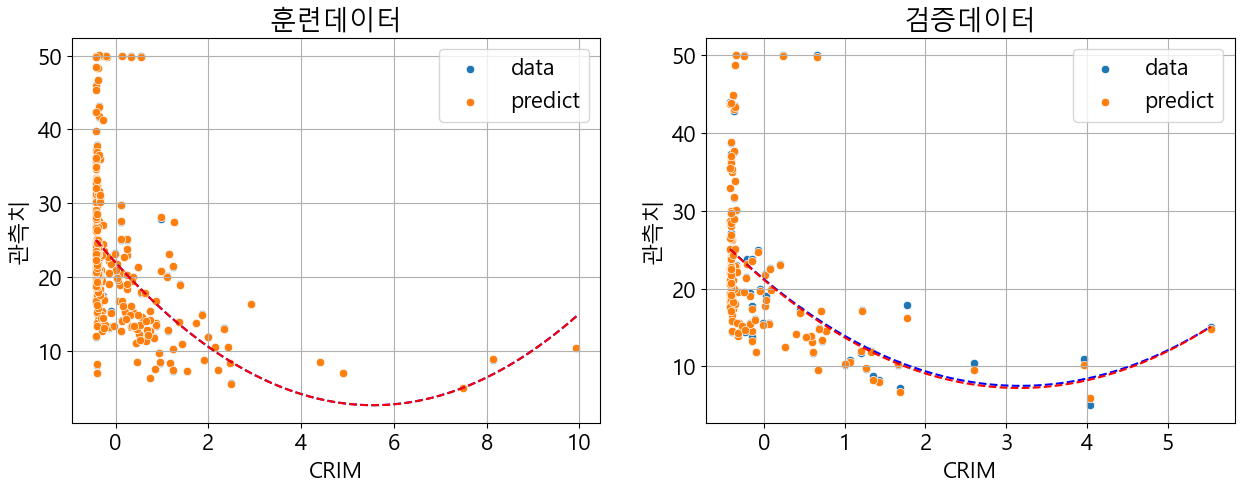

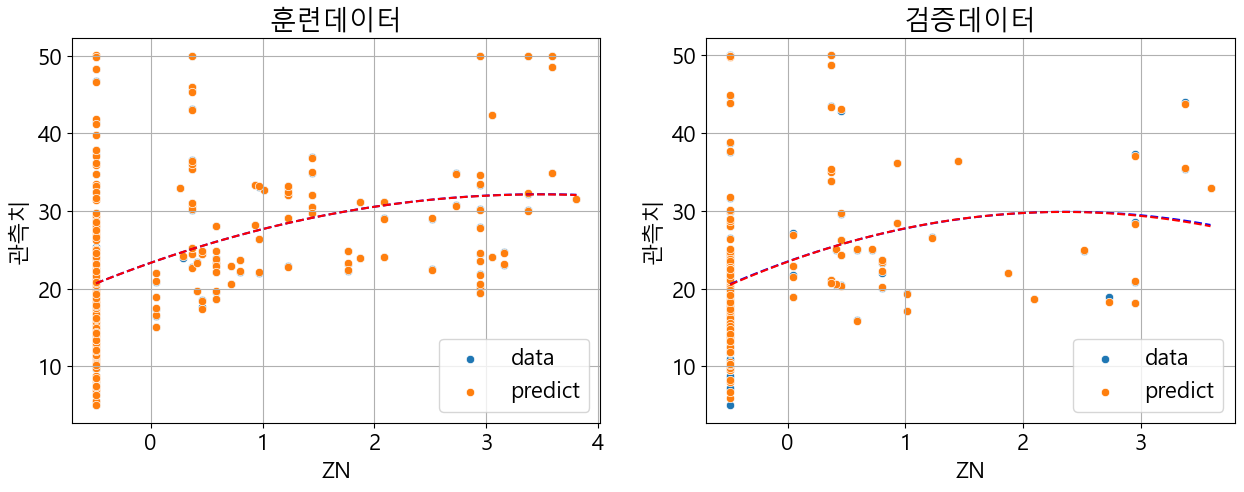

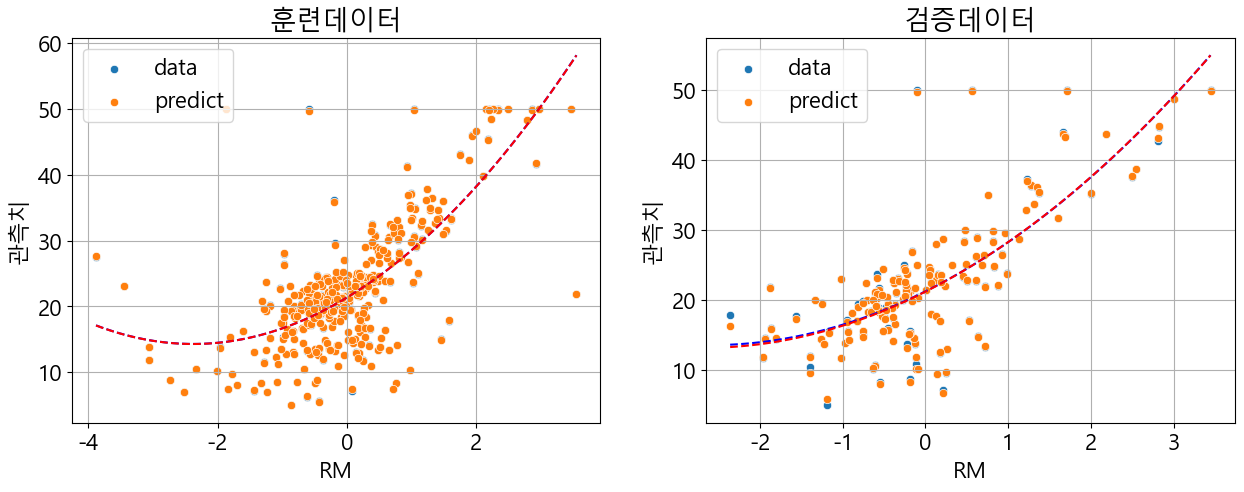

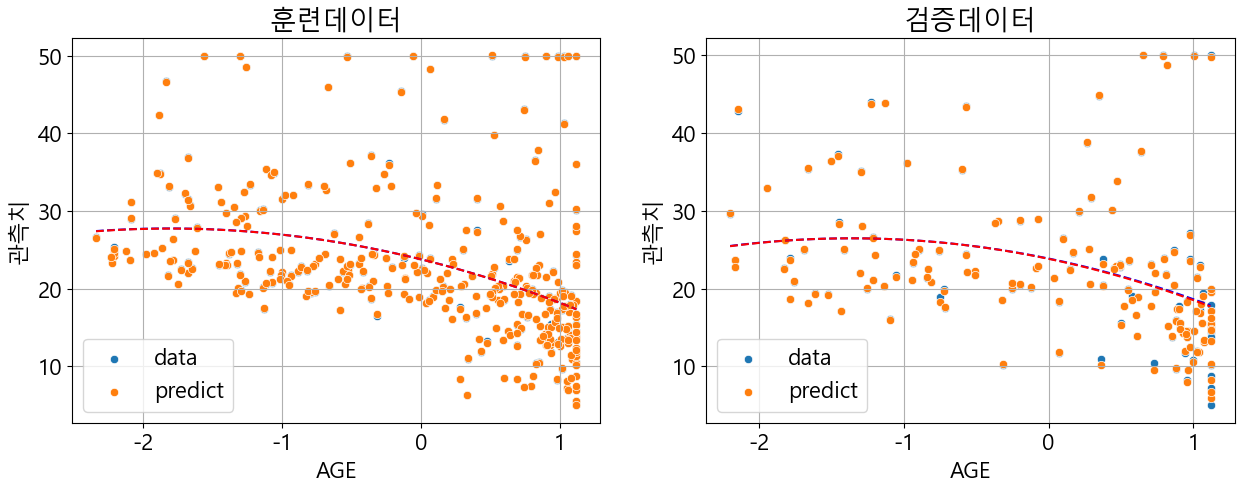

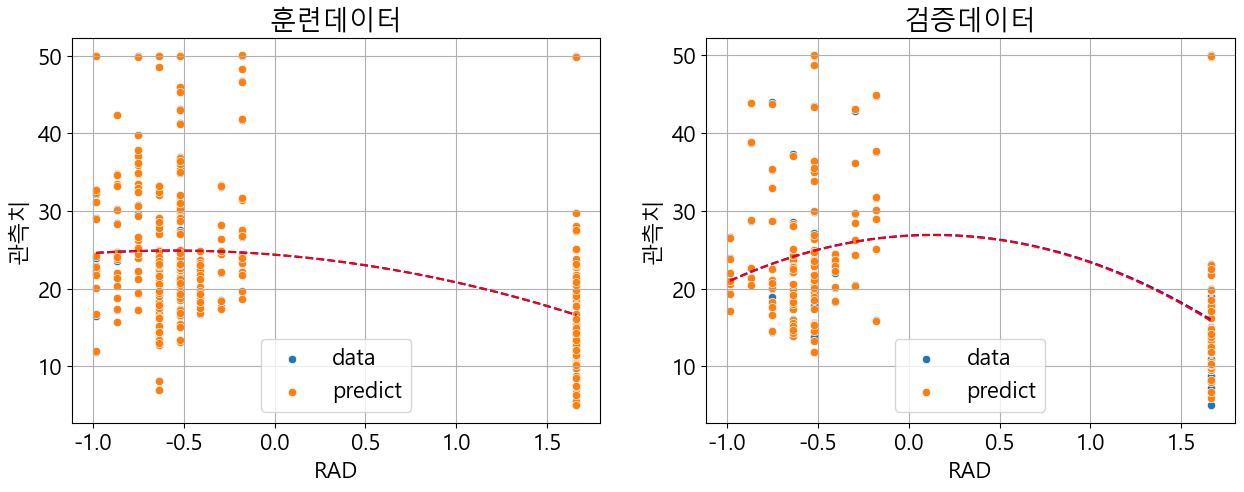

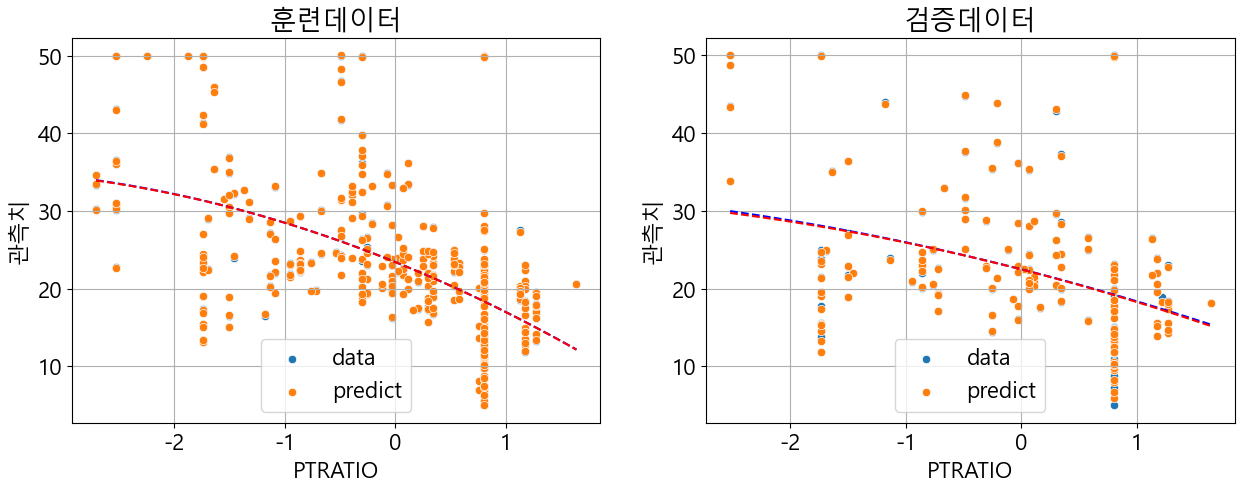

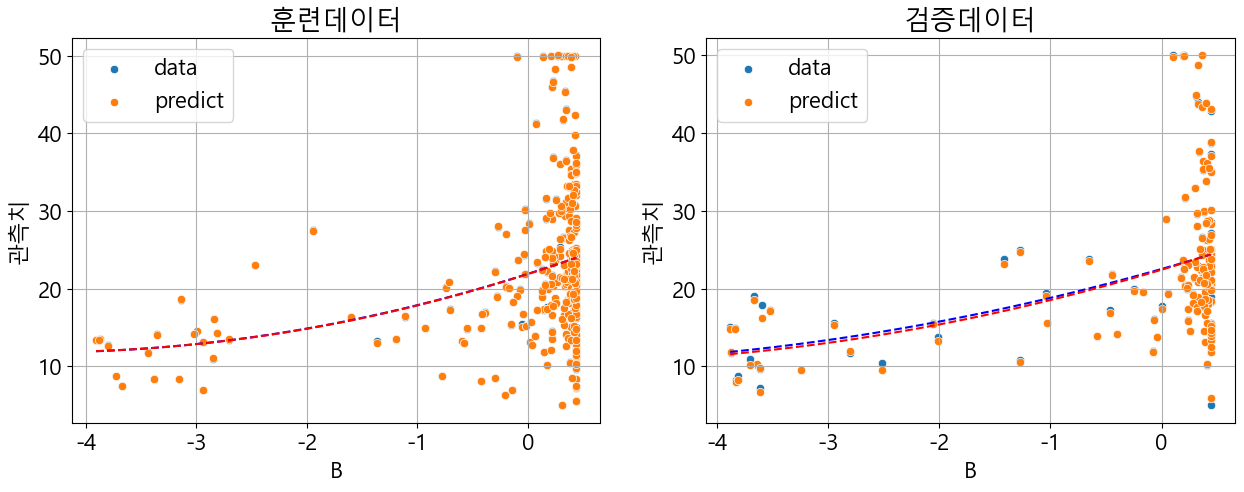

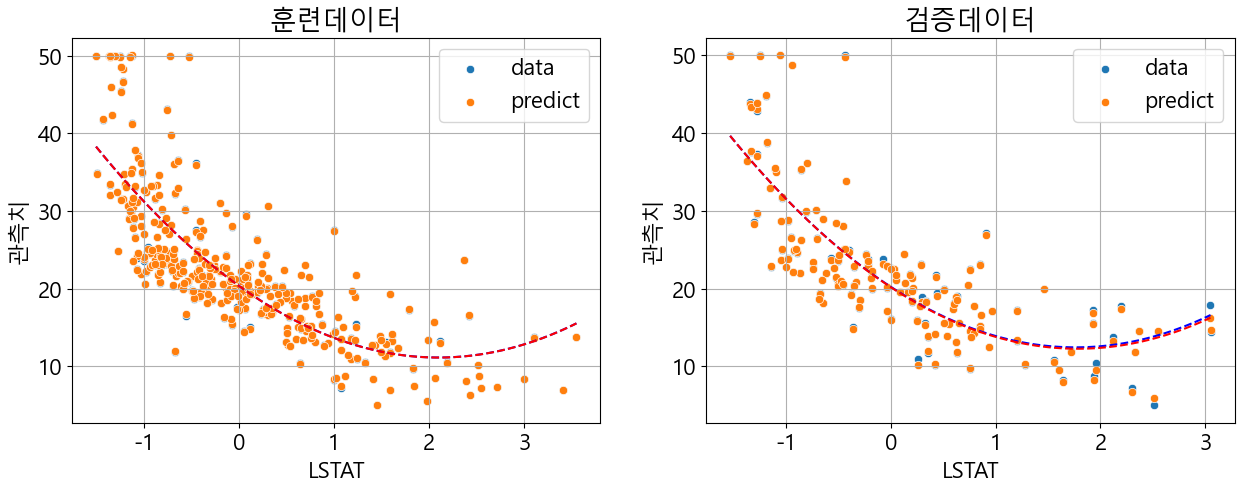

In [30]:
for key in ['CRIM','ZN', 'RM', 'AGE', 'RAD', 'PTRATIO',	'B', 'LSTAT']:
    helper.regplot(train_df[key], train_df['관측치'], train_df['예측치'], "훈련데이터",
                    test_df[key], test_df['관측치'], test_df['예측치'], "검증데이터",
                    figsize=(15,5))